<a href="https://colab.research.google.com/github/abhiramp1/LCLU_databytes/blob/main/LCLU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pyshp is a Python shapefile libraty that provides read and writte support for the shapefiles. A shapefile is a gegraphic vector data that stores information such as location (lattitude, Longitude), bounday shape, and attributes of geographic features

In [1]:
#Install Pyshp using pip
!pip install pyshp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 2.8 MB/s eta 0:00:00


# Introduction on using the python libraries
Generally library is a collection of books. In case of Python, a library is a bundled modules with precompiled codes that can be reused for simpler programming and user convenience. Here we are importing some of the libraries required to assess the land use changes in the Payne county. We are using imagery from cropland data layer to assess the landuse change during the years 2020, 2021, and 2022. Before we start we need to know about rasters, a raster is a two-dimensional image stored as a rectangular matrix or grid of square pixels. In this notebook we deal with both rasters and vectors. 

1. The Geospatial Data Abstraction Library (GDAL) is used to read and write vector and raster files. 
2. The NumPy is used to read and manipulate large and multi-dimensional arrays and matrices.
3.  The os library provides functionality to navigate directories in the operating system. In this notebook the OS is to naviate directories, fetch contents. change and identify the existing directory and so on. 
4. The Pandas library is used to perform data analysis while dealing with datasheets and numeric tables
5. The matplotlib library has extensive compatibility with NumPy and is currently used here to plot and visualize the vector and raster datasets. Besides visualizing rawdata, Matplotlib is used to visualized landuse change in Payne county

In [2]:
#Importing the required libraries
from osgeo import gdal, ogr, osr
import numpy as np
from shapefile import Reader
import os
import pandas as pd
from matplotlib import pyplot,patches,colors,ticker

In [3]:
#Cloning the remote repository to access the data
!git clone https://github.com/abhiramp1/LCLU_databytes.git

Cloning into 'LCLU_databytes'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 60 (delta 11), reused 21 (delta 3), pack-reused 0
Unpacking objects: 100% (60/60), 3.92 MiB | 2.06 MiB/s, done.


In [4]:
#provide the path to the required folders
bpath = "/content/LCLU_databytes/data/Payne_county/"
imag_path = "/content/LCLU_databytes/data/images"
code_file = "/content/LCLU_databytes/data/CDL_codes_names_colors.xlsx"

In [5]:
df = pd.read_excel(code_file)
df.head()

,Codes,Class_Names,Unnamed: 2,Erdas_Red,Erdas_Green,Erdas_Blue,Unnamed: 6,ESRI_Red,ESRI_Green,ESRI_Blue
0,0,Background,NaN,0.0,0.0000,0.0000,NaN,0,0,0
1,1,Corn,NaN,1.0,0.8275,0.0000,NaN,255,212,0
2,2,Cotton,NaN,1.0,0.1490,0.1490,NaN,255,38,38
3,3,Rice,NaN,0.0,0.6588,0.8980,NaN,0,169,230
4,4,Sorghum,NaN,1.0,0.6196,0.0471,NaN,255,158,15


(35.940687, 36.246541)

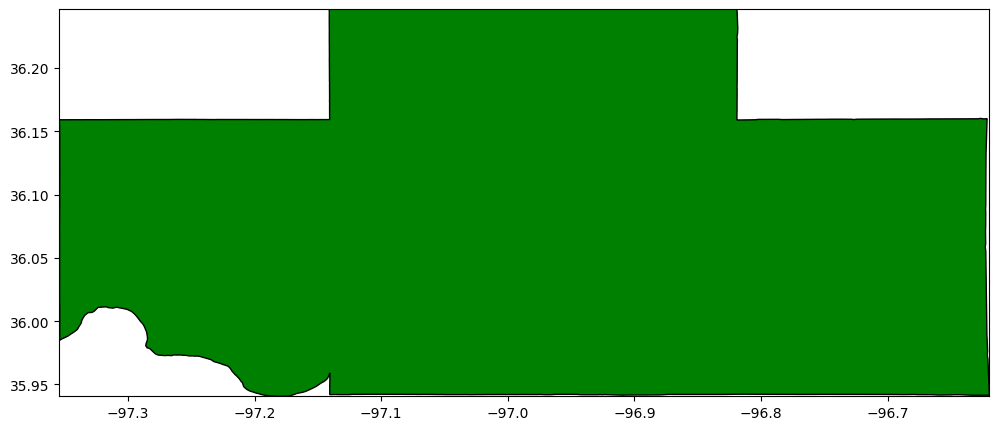

In [7]:
os.chdir(bpath)
sf = Reader("payne.shp")

shape = sf.shape(0)

minx,miny,maxx,maxy = shape.bbox

fig = pyplot.figure(figsize = (12,6))
ax = fig.add_subplot(111, aspect = 'equal')

points = []
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    point = [(i,j) for i,j in zip(x,y)]
    points.append(point)
    ax.add_patch(patches.Polygon(point, ec = 'k', fc = "green"))

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

In [8]:
#opening cdl image using gdal and storing the raster arrays in a list
os.chdir(imag_path)
arr_list = []
for img in os.listdir():
  if img.endswith(".tif"):
    rimage = gdal.Open(img)
    band = rimage.GetRasterBand(1)
    rarray = np.array(band.ReadAsArray())
    arr_list.append(rarray)

In [9]:
#This indicates that the three images are stored as arrays inside a list
len(arr_list)

3

(1682, 2588)
4353016


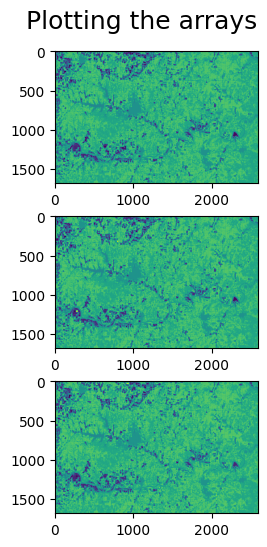

In [27]:
#defining subplot grid
%matplotlib inline
fig, axs = pyplot.subplots(nrows=3, ncols=1, figsize=(12, 6))
pyplot.subplots_adjust(hspace=0.25)
fig.suptitle("Plotting the arrays", fontsize=18, y=0.95)

print(arr_list[0].shape)
print(1682*2588)
axs[0].imshow(arr_list[0])
axs[1].imshow(arr_list[1])
axs[2].imshow(arr_list[2])

In [11]:
# create a transform to project lat/lon onto the raster image

# get the source reference
driver = ogr.GetDriverByName('ESRI Shapefile')
dataset = driver.Open(bpath + "/payne.shp")
inSpatialRef = dataset.GetLayer().GetSpatialRef()
dataset = None

# get the destination reference
dataset = gdal.Open(imag_path + "/CDL_2020_clip_20230329101614_1349936043.tif")
prj = dataset.GetProjection()
outSpatialRef = osr.SpatialReference(wkt=prj)
dataset = None

# create the transform
transform = osr.CoordinateTransformation(inSpatialRef, outSpatialRef)

(-124935.0, 30.0, 0.0, 1475505.0, 0.0, -30.0)


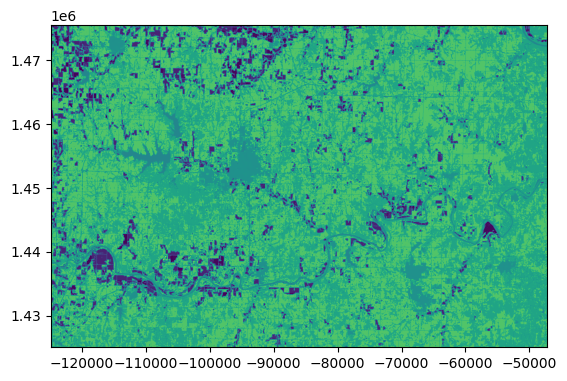

In [12]:
#getting the extent of the shapefile
dataset = gdal.Open(imag_path + "/CDL_2020_clip_20230329101614_1349936043.tif")
band   = dataset.GetRasterBand(1)
data   = np.array(band.ReadAsArray())
geoTrans = dataset.GetGeoTransform()
x0, width, x_rotation, y0, y_rotation, height = geoTrans
print(geoTrans)
extent = x0, x0 + len(data[0]) * width, y0 + len(data) * height, y0
pyplot.imshow(arr_list[0], extent = extent)

(1432958.2258915675, 1466528.239044208)

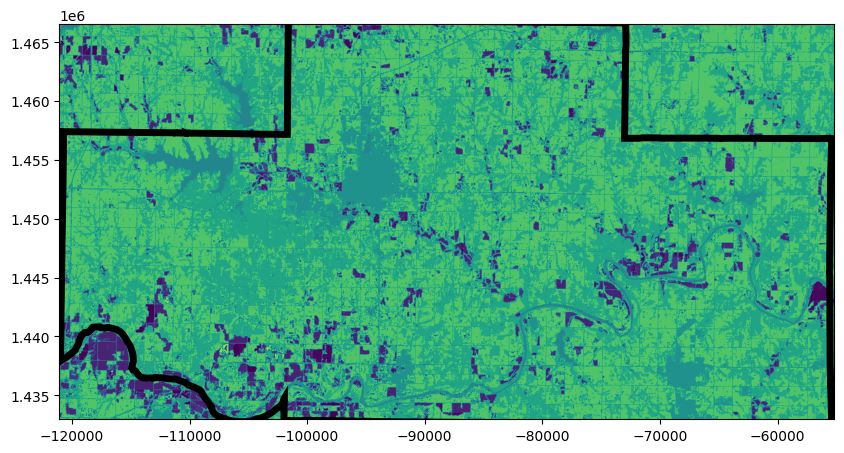

In [16]:
#Transform the points to raster space and plot them
#%matplotlib inline
fig = pyplot.figure(figsize = (10,6))
ax = fig.add_subplot(111, aspect = 'equal')

for shape in sf.shapes():
    parts = shape.parts
    parts.append(len(shape.points))
    for i, j in zip(parts[:-1], parts[1:]):
        boundary = []
        for p in shape.points[i:j]:
            x,y,z = transform.TransformPoint(p[0], p[1])
            boundary.append((x, y))
        ax.add_patch(patches.Polygon(boundary, fc = 'None', ec = 'k',lw = 5))
ax.imshow(arr_list[0], extent = extent)

xmi, ymi, dummy = transform.TransformPoint(minx, miny)
xma, yma, dummy = transform.TransformPoint(maxx, maxy)

ax.set_xlim(xmi, xma)
ax.set_ylim(ymi, yma)

In [18]:
print(len(np.unique(arr_list[0])), len(np.unique(arr_list[1])), len(np.unique(arr_list[2])))

43 38 39


In [19]:
zarr = np.zeros((256,3))
count = 0
for i in arr_list:
  values = i.flatten()
  values = values[values.nonzero()]
  tot_pixels = len(values)
  for v in np.unique(values):
    pixels = np.argwhere(values == v)
    f = len(values[pixels])/tot_pixels*100
    zarr[v,count] = f
  count = count + 1

In [20]:
n = 5
top = np.zeros((n,3))
top_labels = np.zeros((n,3)).astype(int)
for j in range(3):
  count = 0
  top_labels[:,j] = np.argpartition(zarr[:,j],-n)[-n:]
  for i in top_labels[:,j]:
    top[count,j] = zarr[i,j]
    count = count + 1

In [21]:
top_labels

array([[111, 122, 122],
       [121, 121,  24],
       [ 24, 141, 121],
       [141,  24, 141],
       [176, 176, 176]])

([<matplotlib.patches.Wedge at 0x7fca7b2bf040>,
 [Text(1.0978144034095583, 0.06930754408082639, 'Developed/Low Intensity'),
  Text(1.0451048492625115, 0.3431557285664683, 'Winter Wheat'),
  Text(0.893402919169244, 0.6417407763418759, 'Developed/Open Space'),
  Text(-0.07162596881250136, 1.097665577756573, 'Deciduous Forest'),
  Text(-0.6204099595656334, -0.9083454640563629, 'Grass/Pasture')],
 [Text(0.5988078564052136, 0.03780411495317803, '2.0%'),
  Text(0.5700571905068244, 0.18717585194534633, '6.1%'),
  Text(0.4873106831832239, 0.350040423459205, '3.6%'),
  Text(-0.03906871026136437, 0.5987266787763124, '28.6%'),
  Text(-0.33840543249034544, -0.4954611622125615, '50.2%')])

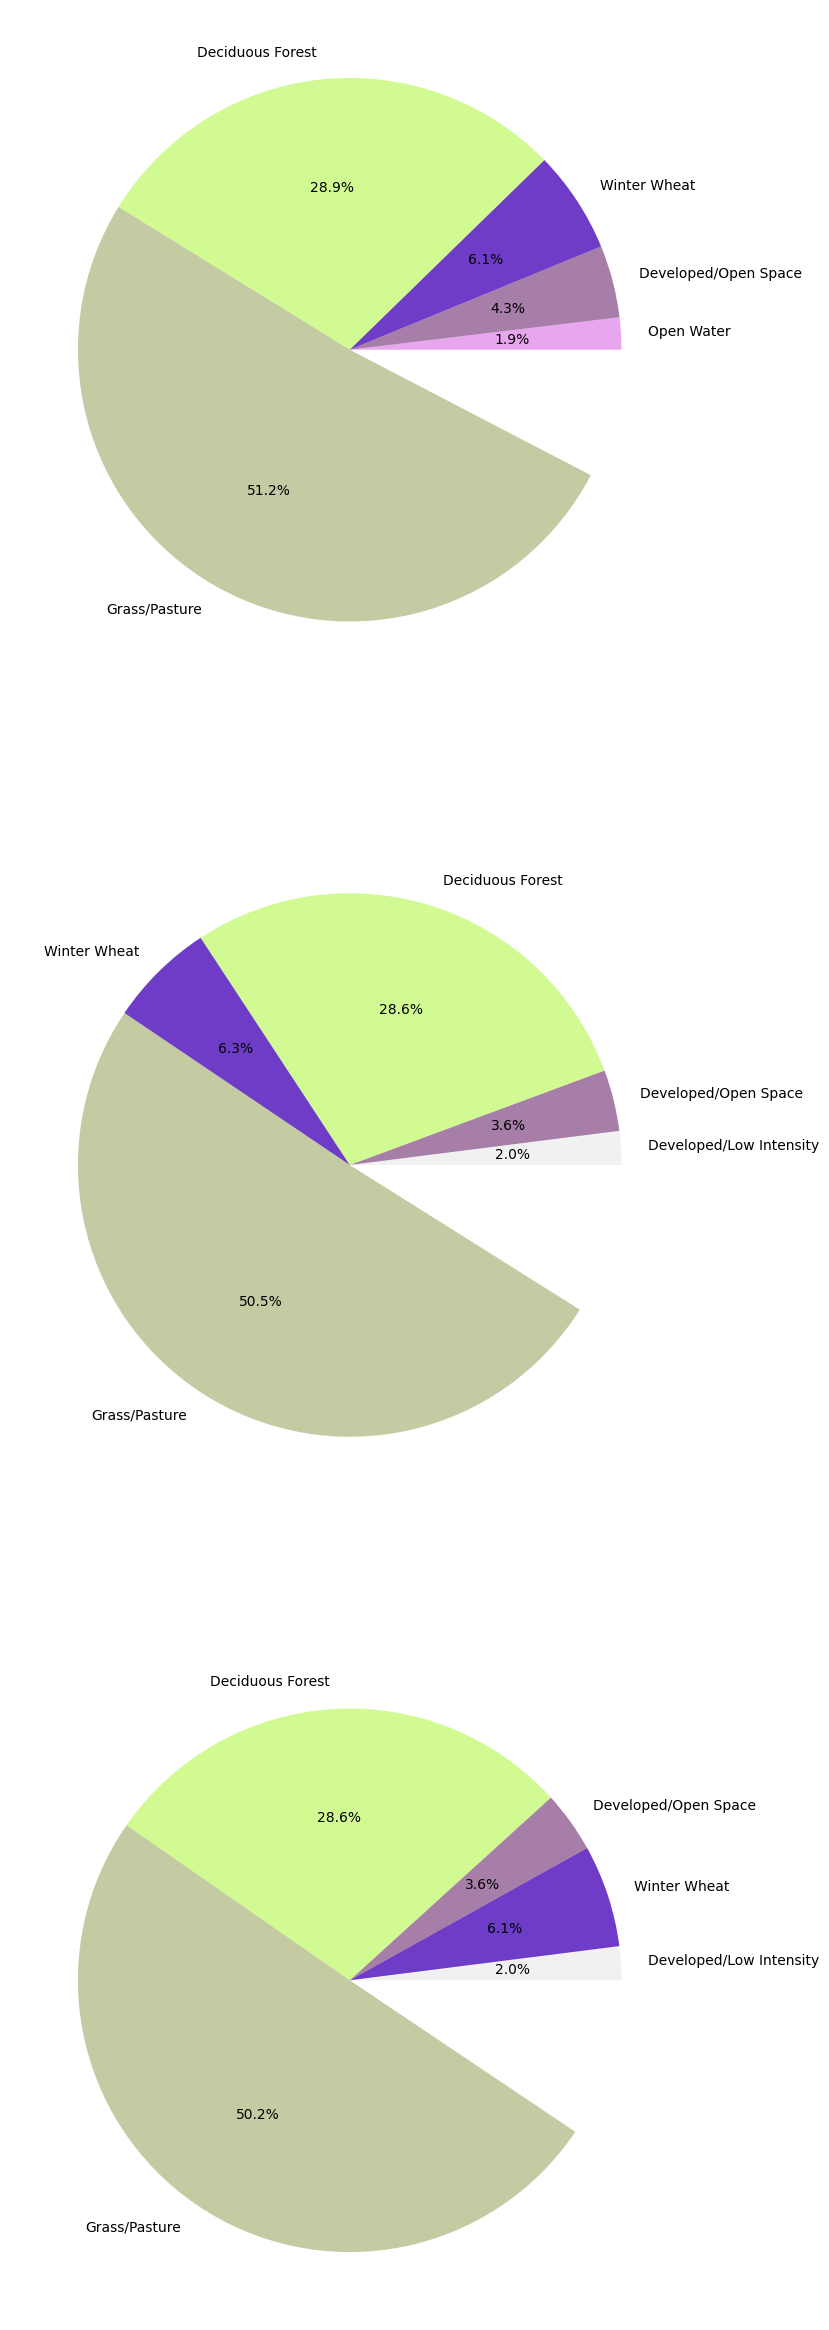

In [24]:
colors = np.random.rand(256,4)
def cmap(i):
  return colors[i]
labels = df["Class_Names"]
fig, ax = pyplot.subplots(nrows = 3, ncols = 1, figsize = (10,30))
ax[0].pie(top[:,0]/100, autopct='%1.1f%%', normalize=False, labels = labels[top_labels[:,0]], colors = cmap(top_labels[:,0]))
ax[1].pie(top[:,1]/100, autopct='%1.1f%%', normalize=False, labels = labels[top_labels[:,1]], colors = cmap(top_labels[:,1]))
ax[2].pie(top[:,2]/100, autopct='%1.1f%%', normalize=False, labels = labels[top_labels[:,2]], colors = cmap(top_labels[:,2]))